# Notebook where we generate melodi buoys associated df

In [1]:
import xarray as xr
import shapefile as shp 
import numpy as np
import matplotlib.pyplot as plt
import SWOT_tools as st
import pandas as pd
from shapely.geometry import box
from shapely.wkt import loads  # In case your polygons are stored as WKT strings
import scipy 
from scipy.interpolate import griddata
from scipy.ndimage import binary_dilation
import matplotlib.patches as patches
from datetime import datetime
from tqdm import tqdm
import os

#plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})


In [2]:
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})

import matplotlib.font_manager as fm
# Regular and bold font paths
font_regular_path = "fonts/times/times.ttf"
font_bold_path = "fonts/times/timesbd.ttf"  # Bold
# Register both fonts
fm.fontManager.addfont(font_regular_path)
fm.fontManager.addfont(font_bold_path)
# Create font properties
font_regular = fm.FontProperties(fname=font_regular_path)
font_bold = fm.FontProperties(fname=font_bold_path)
# Set default font to regular Times New Roman
plt.rcParams['font.family'] = font_regular.get_name()

In [3]:
ds_ww3 = xr.open_mfdataset("/home/datawork-WW3/PROJECT/SWOT/HR-WW3/TEST_DIA_202505_CUR/*.nc", engine="netcdf4")
ds_ww3 = ds_ww3.sel(longitude=slice(-30,10), latitude=slice(50, 80))

In [4]:
lon_ww3, lat_ww3 = ds_ww3.longitude.values, ds_ww3.latitude.values
x_grid_ww3, y_grid_ww3 = np.meshgrid(lon_ww3, lat_ww3)
x_grid_ww3.shape

(241, 321)

In [5]:
#interpolated_values_on_grid = griddata(points, values, (grid_x, grid_y), method='linear') # ligne de code pour se rappeler comment ça marche

In [6]:
val = ds_ww3["hs"].interp(longitude=2.05, latitude=69.98, time="2025-05-02T06:34:47").compute().item() #.interp(...) → lazy Dask object for that variable only; .compute() → loads just the needed chunks; .item() → converts from a 0-D numpy array to a Python float.
print(val)

2.0672898887194524


In [7]:
ds_m = xr.open_dataset("data/melodi/combined_buoy_data_CF16_3.nc")
ds_m = ds_m.sortby(ds_m.time)

In [8]:
from time import time

b_labels = np.array([60,66,71,72]) # for Lofoten eddy #np.array([66, 71, 72, 64, 68, 61, 75])
#name = ["Lofoten Eddy", "Lofoten Eddy", "Lofoten Eddy", "Northern Iceland", "Northern Iceland", "South-West Iceland", "South-West Iceland"]

df = pd.DataFrame({"lon_b":[],
                   "lat_b":[],
                   "WW3_Hs_on_b":[],
                   "Hs_b":[],
                   "Hs_b_filt":[],
                   "b_type":[],
                   "datetime":[],
                   "idx_no_nan":[],
                   "b_lab":[]})#,
                   #"u_va":[],
                   #"v_va":[],
                   #"u_cyclo_va":[],
                   #"v_cyclo_va":[],
                   #"ssh_va":[]})

t0 = time()
ds_buoys = ds_m
for i, b_lab in enumerate(b_labels):
    ds_buoy = ds_buoys.where(ds_buoys["buoy_label"]==b_lab)
    #ds_buoy = ds_buoy.sel(time=slice("2025-04-22","2025-05-28"))
    ds_buoy = ds_buoy.sel(time=slice("2025-05-01","2025-05-16"))
    idx_no_nan = np.argwhere((~np.isnan(ds_buoy.hs.values) & ~np.isnan(ds_buoy.longitude.values))) #np.argwhere(~np.isnan(ds_buoy.hs.values)) 
    Lons_buoy, Lats_buoy, Times_buoy, Hs_buoy = ds_buoy.longitude.values, ds_buoy.latitude.values, ds_buoy.time.values, ds_buoy.hs.values #.dt.decimal_year.values#[idx_no_nan]
    Hs_buoy_filtered = scipy.signal.medfilt(Hs_buoy[idx_no_nan], 5)
    #Hs_m_time_series = []
    
    for i, idx in enumerate(idx_no_nan):
        if i%500 == 0:
            print(f"Progress: {round(100*i/idx_no_nan.shape[0], 2)} %")
            print(f"Elapsed time: {(time() - t0)//60} m {round((time() - t0)%60,0)} s")
        lon_buoy = Lons_buoy[idx][0]
        lat_buoy = Lats_buoy[idx][0]
        time_buoy = Times_buoy[idx][0]
        hs_b = Hs_buoy[idx][0]
        hs_b_filt = Hs_buoy_filtered[i]

        # On interpole ww3 sur la bouée
        hs_ww3= ds_ww3["hs"].interp(longitude=lon_buoy, latitude=lat_buoy, time=time_buoy).compute().item() 

        new_row = pd.DataFrame({"lon_b":[lon_buoy],
                                "lat_b":[lat_buoy],
                                "WW3_Hs_on_b":[hs_ww3],
                                "Hs_b":[hs_b],
                                "Hs_b_filt":[hs_b_filt],
                                "b_type":["m"],
                                "datetime":[Times_buoy[idx][0]],
                                "idx_no_nan":[int(idx[0])],
                                "b_lab":[b_lab]})
        

        df = pd.concat((df, new_row))



 

/dev/shm/pbs.3824536.datarmor0/ipykernel_22009/79169281.py:29: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  Hs_buoy_filtered = scipy.signal.medfilt(Hs_buoy[idx_no_nan], 5)
/dev/shm/pbs.3824536.datarmor0/ipykernel_22009/79169281.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((df, new_row))


Progress: 0.0 %
Elapsed time: 0.0 m 0.0 s
Progress: 15.96 %
Elapsed time: 0.0 m 38.0 s
Progress: 31.92 %
Elapsed time: 1.0 m 16.0 s
Progress: 47.88 %
Elapsed time: 1.0 m 54.0 s
Progress: 63.84 %
Elapsed time: 2.0 m 33.0 s
Progress: 79.8 %
Elapsed time: 3.0 m 12.0 s
Progress: 95.75 %
Elapsed time: 3.0 m 51.0 s


/dev/shm/pbs.3824536.datarmor0/ipykernel_22009/79169281.py:29: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  Hs_buoy_filtered = scipy.signal.medfilt(Hs_buoy[idx_no_nan], 5)


Progress: 0.0 %
Elapsed time: 4.0 m 0.0 s
Progress: 15.09 %
Elapsed time: 4.0 m 40.0 s
Progress: 30.18 %
Elapsed time: 5.0 m 19.0 s
Progress: 45.28 %
Elapsed time: 5.0 m 58.0 s
Progress: 60.37 %
Elapsed time: 6.0 m 38.0 s
Progress: 75.46 %
Elapsed time: 7.0 m 16.0 s
Progress: 90.55 %
Elapsed time: 7.0 m 55.0 s


/dev/shm/pbs.3824536.datarmor0/ipykernel_22009/79169281.py:29: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  Hs_buoy_filtered = scipy.signal.medfilt(Hs_buoy[idx_no_nan], 5)


Progress: 0.0 %
Elapsed time: 8.0 m 17.0 s
Progress: 15.5 %
Elapsed time: 8.0 m 56.0 s
Progress: 31.01 %
Elapsed time: 9.0 m 34.0 s
Progress: 46.51 %
Elapsed time: 10.0 m 13.0 s
Progress: 62.02 %
Elapsed time: 10.0 m 52.0 s
Progress: 77.52 %
Elapsed time: 11.0 m 30.0 s
Progress: 93.02 %
Elapsed time: 12.0 m 9.0 s


/dev/shm/pbs.3824536.datarmor0/ipykernel_22009/79169281.py:29: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  Hs_buoy_filtered = scipy.signal.medfilt(Hs_buoy[idx_no_nan], 5)


Progress: 0.0 %
Elapsed time: 12.0 m 26.0 s
Progress: 15.68 %
Elapsed time: 13.0 m 4.0 s
Progress: 31.36 %
Elapsed time: 13.0 m 43.0 s
Progress: 47.04 %
Elapsed time: 14.0 m 21.0 s
Progress: 62.72 %
Elapsed time: 14.0 m 60.0 s
Progress: 78.39 %
Elapsed time: 15.0 m 39.0 s
Progress: 94.07 %
Elapsed time: 16.0 m 17.0 s


In [13]:
omb_labels = ["OMB-2024-14", "OMB-2024-15", "OMB-2024-19", "OMB-2024-20"]
ds_ombs = xr.open_dataset(r"data/omb/2025-otc-omb.nc")


for i, b_lab in tqdm(enumerate(omb_labels)):
    t_ini ='2025-05-01T00:00:00'
    t_end='2025-05-16T00:00:00'
    #ds_buoy = ds_buoy.sel(time=slice("2025-05-01","2025-05-16"))
    ds_buoy = ds_ombs.sel(trajectory=b_lab).copy()
    ds_buoy = ds_buoy.isel(frequencies_waves_imu=0)
    ds_buoy = ds_buoy.sortby(ds_buoy.time)
    ds = ds_buoy
    
    ds = ds.where(ds.time > np.datetime64(t_ini + '.000000000'), drop=True)
    ds = ds.where(ds.time < np.datetime64(t_end + '.000000000'), drop=True)
    ds = ds.where(ds.time_waves_imu > np.datetime64(t_ini + '.000000000'), drop=True)
    ds = ds.where(ds.time_waves_imu < np.datetime64(t_end + '.000000000'), drop=True)
    time_all = ds.time.values[:,0]
    time_waves_imu_with_nat = ds.time_waves_imu.values[:,0]
    time_waves_imu = time_waves_imu_with_nat[~np.isnat(time_waves_imu_with_nat)] # on vire les nat 
    
    lon = ds.lon.values
    lon = lon[np.isfinite(lon)]
    lat = ds.lat.values
    lat = lat[np.isfinite(lat)]
    Hs0 = ds.Hs0.values[:,0]
    pHs0 = ds.pHs0.values[:,0]
    
    # Get indices in time_all where each time_waves_imu would be inserted
    indices = np.searchsorted(time_all, time_waves_imu, side='right') - 1
    
    # Handle case where the wave time is earlier than all in time_all
    indices[indices < 0] = -1  # or np.nan if preferred
    
    indices_p_1 = [idx + 1 for idx in indices]
    try:
        dt_time_all = (time_all[indices_p_1] - time_all[indices] ) / np.timedelta64(1,'h')
    except IndexError:
        dt_time_all = np.ones(indices.shape)
        dt_time_all[:-1] = (time_all[indices_p_1[:-1]] - time_all[indices[:-1]] ) / np.timedelta64(1,'h')
        dt_time_all[-1] = dt_time_all[-2]
        
    delta_t = (time_waves_imu - time_all[indices]) / np.timedelta64(1, 'h')
    
    Weights = delta_t / dt_time_all
    try:
        lon_waves_imu = Weights*lon[indices_p_1] + (1-Weights)*lon[indices]
        lat_waves_imu = Weights*lat[indices_p_1] + (1-Weights)*lat[indices]
    except IndexError:
        lon_waves_imu, lat_waves_imu = np.ones(Weights.shape), np.ones(Weights.shape)
        lon_waves_imu[:-1] = Weights[:-1]*lon[indices_p_1[:-1]] + (1-Weights[:-1])*lon[indices[:-1]]
        lat_waves_imu[:-1] = Weights[:-1]*lat[indices_p_1[:-1]] + (1-Weights[:-1])*lat[indices[:-1]]
        lon_waves_imu[-1] = lon_waves_imu[-2]
        lat_waves_imu[-1] = lat_waves_imu[-2]

    idx_no_nan = np.argwhere((~np.isnan(ds.Hs0.values[:,0]) & ~np.isnan(ds.lon.values[0,:]))) #np.argwhere(~np.isnan(ds_buoy.hs.values)) 
    Lons_buoy, Lats_buoy, Times_buoy, Hs_buoy = lon, lat, time_waves_imu, Hs0
    Hs_buoy_filtered = scipy.signal.medfilt(Hs_buoy[idx_no_nan], 5)
    #Hs_m_time_series = []
    
    for i, idx in enumerate(idx_no_nan):
        if i%10 == 0:
            print(f"Progress: {round(100*i/idx_no_nan.shape[0], 2)} %")
        lon_buoy = Lons_buoy[idx][0]
        lat_buoy = Lats_buoy[idx][0]
        time_buoy = Times_buoy[idx][0]
        hs_b = Hs_buoy[idx][0]
        hs_b_filt = Hs_buoy_filtered[i]

        # On interpole ww3 sur la bouée
        hs_ww3= ds_ww3["hs"].interp(longitude=lon_buoy, latitude=lat_buoy, time=time_buoy).compute().item() 

        new_row = pd.DataFrame({"lon_b":[lon_buoy],
                                "lat_b":[lat_buoy],
                                "WW3_Hs_on_b":[hs_ww3],
                                "Hs_b":[hs_b],
                                "Hs_b_filt":[hs_b_filt],
                                "b_type":["omb"],
                                "datetime":[Times_buoy[idx][0]],
                                "idx_no_nan":[int(idx[0])],
                                "b_lab":[b_lab]})
        

        df = pd.concat((df, new_row))

0it [00:00, ?it/s]/dev/shm/pbs.3824536.datarmor0/ipykernel_22009/916160439.py:58: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  Hs_buoy_filtered = scipy.signal.medfilt(Hs_buoy[idx_no_nan], 5)


Progress: 0.0 %
Progress: 8.33 %
Progress: 16.67 %
Progress: 25.0 %
Progress: 33.33 %
Progress: 41.67 %
Progress: 50.0 %
Progress: 58.33 %
Progress: 66.67 %
Progress: 75.0 %
Progress: 83.33 %
Progress: 91.67 %


1it [00:12, 12.21s/it]/dev/shm/pbs.3824536.datarmor0/ipykernel_22009/916160439.py:58: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  Hs_buoy_filtered = scipy.signal.medfilt(Hs_buoy[idx_no_nan], 5)


Progress: 0.0 %
Progress: 8.26 %
Progress: 16.53 %
Progress: 24.79 %
Progress: 33.06 %
Progress: 41.32 %
Progress: 49.59 %
Progress: 57.85 %
Progress: 66.12 %
Progress: 74.38 %
Progress: 82.64 %
Progress: 90.91 %


2it [00:24, 11.98s/it]

Progress: 99.17 %


/dev/shm/pbs.3824536.datarmor0/ipykernel_22009/916160439.py:58: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  Hs_buoy_filtered = scipy.signal.medfilt(Hs_buoy[idx_no_nan], 5)


Progress: 0.0 %
Progress: 8.26 %
Progress: 16.53 %
Progress: 24.79 %
Progress: 33.06 %
Progress: 41.32 %
Progress: 49.59 %
Progress: 57.85 %
Progress: 66.12 %
Progress: 74.38 %
Progress: 82.64 %
Progress: 90.91 %


3it [00:35, 11.96s/it]

Progress: 99.17 %


/dev/shm/pbs.3824536.datarmor0/ipykernel_22009/916160439.py:58: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  Hs_buoy_filtered = scipy.signal.medfilt(Hs_buoy[idx_no_nan], 5)


Progress: 0.0 %
Progress: 8.4 %
Progress: 16.81 %
Progress: 25.21 %
Progress: 33.61 %
Progress: 42.02 %
Progress: 50.42 %
Progress: 58.82 %
Progress: 67.23 %
Progress: 75.63 %
Progress: 84.03 %
Progress: 92.44 %


4it [00:47, 11.92s/it]


In [21]:
df.to_csv("B_df/df_ww3_on_lofoten_buoys.csv")

In [106]:
def pearson_correlation(x_obs, y_obs):
    x = np.array(x_obs)
    y = np.array(y_obs)
    
    x_bar = np.mean(x)
    y_bar = np.mean(y)

    numerator = np.sum((x - x_bar) * (y - y_bar))
    denominator = np.sqrt(np.sum((x - x_bar)**2) * np.sum((y - y_bar)**2))

    if denominator == 0:
        raise ValueError("Denominator is zero; correlation is undefined.")
    
    return numerator / denominator

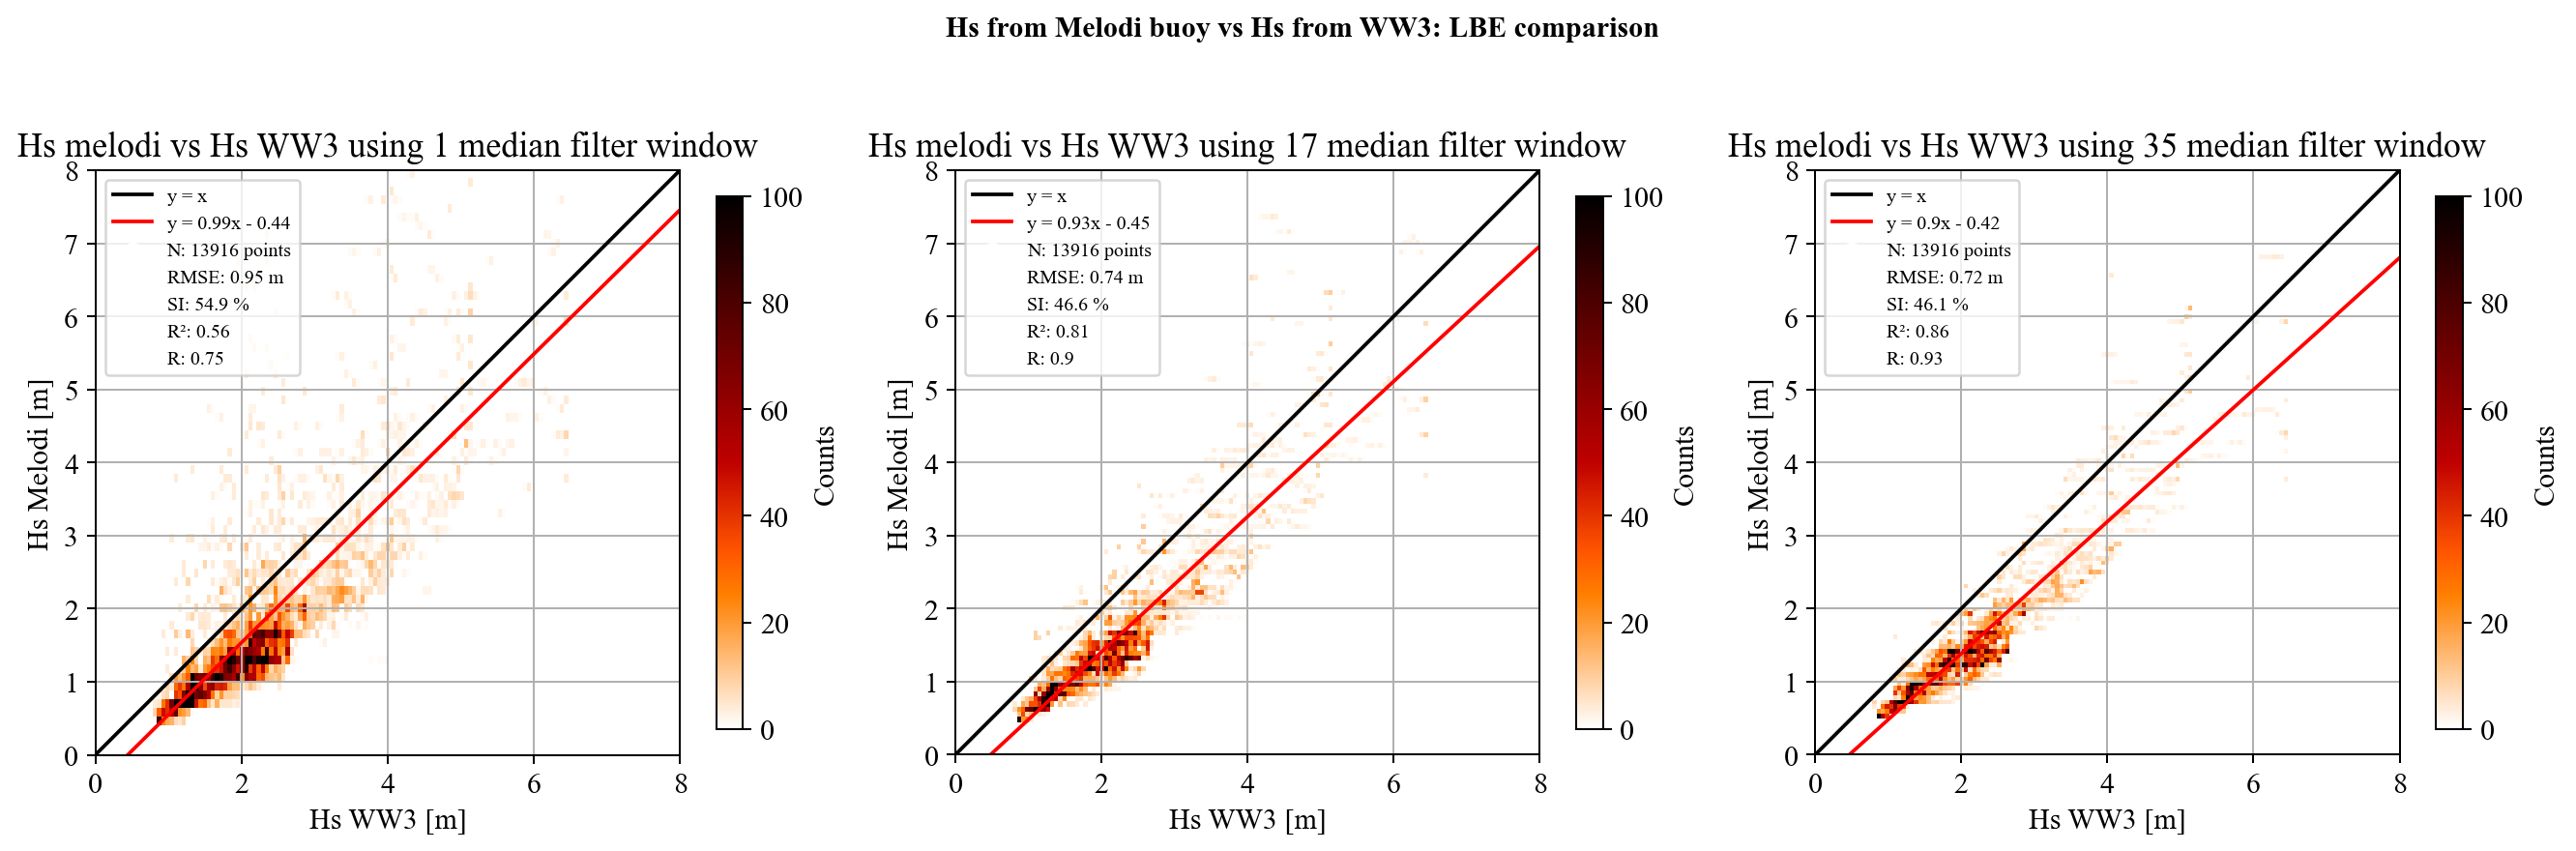

In [120]:
plt.rcParams.update({'font.size': 12})  

fig, ax = plt.subplots(1,3, figsize = (15,5),dpi=180)


for i, med_filt_window in enumerate([1,17,35]):
    df = pd.read_csv("ww3_on_melodi.csv")
    df = df.dropna(subset=["WW3_Hs_on_b"])
    Hs_buoy_filtered = scipy.signal.medfilt(df["Hs_b"].values, med_filt_window)
    x_obs, y_obs = df["WW3_Hs_on_b"].values, Hs_buoy_filtered

    R = pearson_correlation(x_obs, y_obs)
    RMSE = round(np.sqrt(np.mean((x_obs-y_obs)**2)),2)

    
    # DENSITY SCATTERPLOT REPLACEMENT
    _, _, _, imi = ax[i].hist2d(x_obs, y_obs, bins=100, cmap='gist_heat_r', vmin=0, vmax=100)
    fig.colorbar(imi, ax=ax[i], orientation='vertical', label='Counts', shrink=0.71)

    
    x_id, y_id = np.arange(0, 10, 0.1), np.arange(0, 10, 0.1)
    
    ax[i].plot(x_id, y_id, color="black", label="y = x")
    
    coeffs = np.polyfit(x_obs.flatten(), y_obs.flatten(), deg=1) 
    a, b = coeffs[0], coeffs[1]

    y_pred = a*x_obs+b
    R2 = round(1 - np.sum((y_obs - y_pred)**2) / np.sum((y_obs - np.mean(y_obs))**2), 2)

    N = x_obs.shape[0]

    SI = round(100* RMSE / np.mean(y_obs), 1)
    
    
    if b > 0:
        ax[i].plot(x_id, a*x_id+b,color="red",label=f"y = {round(a,2)}x + {round(b,2)}")
    else: 
        ax[i].plot(x_id, a*x_id+b,color="red",label=f"y = {round(a,2)}x - {round(abs(b),2)}")


    plt.rcParams.update({'font.size': 8})  
    ax[i].scatter(-1,-1, color="white", label=f"N: {N} points")    
    ax[i].scatter(-1,-1, color="white", label=f"RMSE: {RMSE} m")
    ax[i].scatter(-1,-1, color="white", label=f"SI: {SI} %")
    ax[i].scatter(-1,-1, color="white", label=f"R²: {R2}")
    ax[i].scatter(-1,-1, color="white", label=f"R: {round(R,2)}")
    ax[i].legend(loc="upper left")

    #ax[i].scatter(-1,-1, color="white", label=f"R²_p: {round(R**2,2)}")

    plt.rcParams.update({'font.size': 12})  
    ax[i].grid()
    ax[i].axis('scaled')
    ax[i].set_xlim(0,8)
    ax[i].set_ylim(0,8)
    ax[i].set_title(f"Hs melodi vs Hs WW3 using {med_filt_window} median filter window")
    #fig.text(0.5, 0.875, " Start IW: {} --- End IW: {} \n Start SWOT: {} --- End SWOT: {} \n ".format(dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'), dt_end_max.strftime('%d/%m/%Y %H:%M:%S'), t_ini_swot_formatted, t_end_swot_formatted), ha='center', fontsize=11)
    ax[i].set_xlabel("Hs WW3 [m]")
    ax[i].set_ylabel("Hs Melodi [m]")
    #plt.xlim(min_xx,max_xx)
    #plt.ylim(min_xx,max_xx)
    #plt.xlim(hs_min,hs_max)
    #plt.ylim(hs_min,hs_max)

    #N_colocs.append(np.unique(df_hs_EXT["swot_file"]).shape[0])
    
#ax[0].set_title(f"(a) ALL FILES: {N_colocs[0]} co-loc cases")
#ax[1].set_title(f"(b) PIC2: {N_colocs[1]} co-loc cases")
#ax[2].set_title(f"(c) PIC0, PGC0: {N_colocs[2]} co-loc cases")
plt.suptitle("Hs from Melodi buoy vs Hs from WW3: LBE comparison", fontproperties=font_bold, fontsize=12)# \n Start IW: {} --- End IW: {} \n Start SWOT: {} --- End SWOT: {} \n ".format(pretitle, dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'), dt_end_max.strftime('%d/%m/%Y %H:%M:%S'), t_ini_swot_formatted, t_end_swot_formatted))
plt.tight_layout()

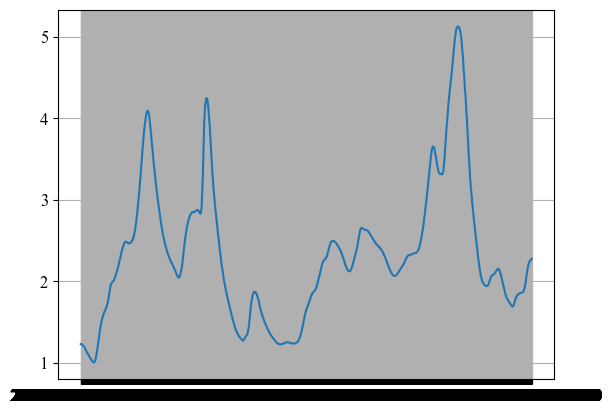

In [110]:
plt.plot(df["WW3_Hs_on_b"].loc[df["b_lab"]==71].values, df["WW3_Hs_on_b"].loc[df["b_lab"]==71].values)
plt.grid()
plt.show()

In [114]:
df["datetime"].loc[df["b_lab"]==71].values[:100]

array(['2025-05-01 00:03:00', '2025-05-01 00:13:00',
       '2025-05-01 00:23:00', '2025-05-01 00:25:00',
       '2025-05-01 00:33:00', '2025-05-01 00:43:00',
       '2025-05-01 00:53:00', '2025-05-01 00:55:00',
       '2025-05-01 01:03:00', '2025-05-01 01:13:00',
       '2025-05-01 01:23:00', '2025-05-01 01:25:00',
       '2025-05-01 01:33:00', '2025-05-01 01:43:00',
       '2025-05-01 01:53:00', '2025-05-01 01:55:00',
       '2025-05-01 02:03:00', '2025-05-01 02:13:00',
       '2025-05-01 02:23:00', '2025-05-01 02:25:00',
       '2025-05-01 02:33:00', '2025-05-01 02:43:00',
       '2025-05-01 02:53:00', '2025-05-01 02:55:00',
       '2025-05-01 03:03:00', '2025-05-01 03:13:00',
       '2025-05-01 03:23:00', '2025-05-01 03:25:00',
       '2025-05-01 03:33:00', '2025-05-01 03:43:00',
       '2025-05-01 03:53:00', '2025-05-01 03:55:00',
       '2025-05-01 04:03:00', '2025-05-01 04:13:00',
       '2025-05-01 04:23:00', '2025-05-01 04:25:00',
       '2025-05-01 04:33:00', '2025-05-01 04:4

In [73]:
np.sum(~np.isnan(ds_buoys.hs.values))

np.int64(54633)

In [81]:
idx_no_nan = np.argwhere((~np.isnan(ds_buoy.hs.values) & ~np.isnan(ds_buoy.longitude.values))) #np.argwhere(~np.isnan(ds_buoy.hs.values)) 

In [82]:
idx_no_nan.shape

(562, 1)

In [85]:
ds_buoys

<xarray.Dataset> Size: 3MB
Dimensions:        (time: 54702)
Coordinates:
  * time           (time) datetime64[ns] 438kB 2025-04-24T09:12:00 ... 2025-0...
Data variables:
    IMEI           (time) object 438kB ...
    hs             (time) float64 438kB nan nan 2.6 2.6 ... 1.9 1.85 2.6 1.85
    hs_available   (time) int8 55kB 0 0 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    sst            (time) float64 438kB ...
    sst_available  (time) int8 55kB ...
    longitude      (time) float64 438kB ...
    latitude       (time) float64 438kB ...
    buoy_label     (time) int32 219kB 60 60 60 60 60 60 60 ... 70 71 73 77 70 77
Attributes:
    Conventions:         CF-1.6
    contact:             alexey.mironov@eodyn.com
    producer:            eOdyn (eodyn.com)
    data_platform:       Stratstaad Lehmkul sailing ship
    date_of_production:  2025-05-28T12:23:27
    data_source:         ESA Ocean Training Courses 2025
    description:         Combined buoy dataset: significant wave height, SST,...